## Optimizing Portfolio Allocation through Reinforcement Learning
This code defines a framework for optimizing a financial portfolio using both reinforcement learning (RL) and traditional Markowitz optimization techniques within a simulated environment. It encompasses the creation of a portfolio environment, the application of Q-learning for investment strategy learning, and the execution of Markowitz optimization to determine the portfolio with the minimum variance for a given target return. The implementation includes several components:

**Portfolio Environment:** Class PortfolioEnv simulates a portfolio optimization environment for RL. It features attributes for the number of steps, expected returns, risks of two stocks, a risk-free rate of return, and tracking of simulated returns. Methods include resetting the environment, taking a step (which simulates stock returns and calculates portfolio returns based on actions), simulating returns over a set number of simulations, and calculating the covariance matrix of simulated returns.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt


class PortfolioEnv:
    """
    A simple portfolio optimization environment for reinforcement learning.
    
    Attributes:
        num_steps (int): The number of steps in the environment.
        stock1_return (float): Expected return of stock 1.
        stock1_risk (float): Risk (standard deviation) of stock 1.
        stock2_return (float): Expected return of stock 2.
        stock2_risk (float): Risk (standard deviation) of stock 2.
        risk_free_rate (float): Risk-free rate of return.
        current_step (int): Current step in the environment.
        done (bool): Whether the episode has ended.
        simulated_returns (list): List of simulated returns for analysis.
    """
    def __init__(self, num_steps=1000, seed=42):
        self.num_steps = num_steps
        self.stock1_return = 0.06/252  # Expected annual return for stock 1
        self.stock1_risk = 0.1/252  # Standard deviation of returns for stock 1
        self.stock2_return = 0.12/252  # Expected annual return for stock 2
        self.stock2_risk = 0.2/252  # Standard deviation of returns for stock 2
        self.risk_free_rate = 0.02/252  # Risk-free rate of return
        self.current_step = 0
        self.done = False
        self.simulated_returns = []
        np.random.seed(seed)
        
    def reset(self):
        """Resets the environment to its initial state."""
        self.current_step = 0
        self.done = False
        self.simulated_returns = []  # Clear previous simulations
        return np.array([1.0, 0.0, 0.0])  # Initial allocation: all in risk-free asset

    def step(self, action):
        """
        Simulates the environment's step based on the provided action.
        
        Args:
            action (list): The action to take, represented by the allocation in [risk-free asset, stock1, stock2].
        
        Returns:
            numpy.ndarray: The returns of each asset for the step.
            float: The total portfolio return for the step.
        """
        # Simulate returns for each stock based on normal distribution
        stock1_ret = np.random.normal(self.stock1_return, self.stock1_risk)
        stock2_ret = np.random.normal(self.stock2_return, self.stock2_risk)
        self.simulated_returns.append([self.risk_free_rate, stock1_ret, stock2_ret])
        
        # Calculate portfolio return based on the action
        portfolio_return = (
            action[0] * self.risk_free_rate +
            action[1] * stock1_ret +
            action[2] * stock2_ret
        )
        
        self.current_step += 1
        if self.current_step >= self.num_steps:
            self.done = True
        
        return np.array([self.risk_free_rate, stock1_ret, stock2_ret]), portfolio_return

    def simulate_returns(self, num_simulations=None):
        """
        Simulates returns over a specified number of simulations or the default number of steps.
        
        Args:
            num_simulations (int, optional): The number of simulations to run. Defaults to num_steps.
        """
        if num_simulations is None:
            num_simulations = self.num_steps
        self.simulated_returns = []
        for _ in range(num_simulations):
            stock1_ret = np.random.normal(self.stock1_return, self.stock1_risk)
            stock2_ret = np.random.normal(self.stock2_return, self.stock2_risk)
            self.simulated_returns.append([self.risk_free_rate, stock1_ret, stock2_ret])
        self.simulated_returns = np.array(self.simulated_returns)
    
    def get_covariance_matrix(self):
        """
        Calculates and returns the covariance matrix of the simulated returns.

        Returns:
            numpy.ndarray: The covariance matrix of the simulated returns.
        """
        if len(self.simulated_returns) == 0:
            print("Returns have not been simulated yet. Call simulate_returns first.")
            return None
        # Convert simulated returns to a DataFrame for easier manipulation
        historical_returns = pd.DataFrame(self.simulated_returns, columns=['Risk_Free', 'Stock1', 'Stock2'])
        # Calculate and return the covariance matrix
        return historical_returns.cov()


**Q-Learning Configuration:** This section sets up the learning rate, discount factor, number of episodes, exploration rate, and defines possible investment actions (allocations across the risk-free asset, stock 1, and stock 2). It initializes the portfolio environment, simulates returns to ensure consistency across episodes, and initializes the Q-table used for learning optimal investment strategies.

In [2]:
# Q-Learning Configuration for Portfolio Optimization
# This section defines the settings for the Q-learning algorithm, which will be used to
# learn the optimal investment strategy over a series of episodes.

# Learning rate (alpha): Determines the extent to which the newly acquired information will override the old information.
# A factor of 0 will make the agent not learn anything, while a factor of 1 would make the agent consider only the most recent information.
learning_rate = 0.1

# Discount factor (gamma): Represents the importance of future rewards.
# A factor of 0 will make the agent short-sighted by only considering current rewards,
# while a factor near 1 will make it strive for long-term high rewards.
discount_factor = 0.5

# Number of episodes: The number of times the learning algorithm will run through the entire process,
# allowing the agent to learn from the environment and update the policy based on received rewards.
num_episodes = 1000

# Exploration rate (epsilon): The probability of choosing a random action instead of the best action.
# It allows the agent to explore the environment by trying different actions and thus avoid local minima.
epsilon = 0.1

# Definition of investment actions:
# Each action represents a different allocation strategy among the available assets: risk-free asset, stock 1, and stock 2.
# The allocations are defined as proportions, where each row in the array corresponds to a specific action the agent can choose.
investment_actions = np.array([
    [1.0, 0.0, 0.0],  # All in risk-free asset
    [0.0, 1.0, 0.0],  # All in stock 1
    [0.0, 0.0, 1.0],  # All in stock 2
    [0.5, 0.5, 0.0],  # 50% in stock 1 and 50% in risk-free
    [0.75, 0.25, 0.0],  # 75% in stock 1 and 25% in risk-free
    [0.25, 0.75, 0.0],  # 25% in stock 1 and 75% in risk-free
    [0.5, 0.0, 0.5],  # 50% in stock 2 and 50% in risk-free
    [0.75, 0.0, 0.25],  # 75% in stock 2 and 25% in risk-free
    [0.25, 0.0, 0.75],  # 25% in stock 2 and 75% in risk-free
    [0.0, 0.5, 0.5],  # 50-50 between stock 1 and stock 2
    [0.0, 0.75, 0.25],  # 75% in stock 1 and 25% in stock 2
    [0.0, 0.25, 0.75],  # 25% in stock 1 and 75% in stock 2
    [1/3, 1/3, 1/3],  # Equally distributed among all three assets
])

# Environment and Q-table Initialization:
# Initialize the portfolio environment and simulate returns based on the predefined settings.
# This environment will be used to simulate the behavior of the stock market and the risk-free asset.
env = PortfolioEnv()  # Create an instance of the environment.
env.simulate_returns()  # Pre-simulate returns for the entire episode duration to ensure consistency.

# Retrieve the covariance matrix of the simulated returns. This matrix is crucial for calculating portfolio variance
# and thus for adjusting rewards based on the risk.
cov_matrix = env.get_covariance_matrix().to_numpy()

# Initialize the Q-table with zeros. The Q-table will store the expected rewards for each action in each state,
# guiding the agent to make the best decisions based on past experiences.
# The dimensions of the Q-table are determined by the number of actions.
q_table = np.zeros((len(investment_actions), len(investment_actions)))


def step(env, action):
    """
    Performs a step in the environment using the given action, returning the result.

    Args:
        env: The portfolio environment instance.
        action: The action to be taken, represented as a vector indicating the allocation percentages for each asset.

    Returns:
        tuple: A tuple containing the next state, reward, whether the episode is done, and an info dict (empty here).
    """
    # Simulate the returns for one step and retrieve the total portfolio return.
    simulated_returns, portfolio_return = env.step(action)
    
    # Calculate portfolio variance as a measure of risk. This calculation uses only the allocations to stocks,
    # as the risk-free asset's variance is zero.
    portfolio_variance = np.dot(action[1:], np.dot(cov_matrix[1:, 1:], action[1:].T))
    
    # Define the risk aversion coefficient. Higher values indicate more aversion to risk.
    lambda_risk_aversion = 0.5
    
    # Calculate the risk-adjusted return as the reward for this action.
    risk_adjusted_return = portfolio_return - lambda_risk_aversion * portfolio_variance
    
    # Set the reward for the action.
    reward = risk_adjusted_return
    
    # Check if the episode is done.
    done = env.done
    
    # The next state is simply defined as the action in this setup.
    next_state = action
    
    return next_state, reward, done, {}


**Training Loop:** It iterates over a defined number of episodes, using the epsilon-greedy strategy to explore or exploit actions based on the Q-table. After each action, it updates the Q-table using the reward from the risk-adjusted return of the portfolio, considering both the return and the variance (risk).

In [3]:
# Training loop
optimal_policies = []  # List to store the optimal policy after each episode.

for episode in range(num_episodes):
    # Reset the environment at the start of each episode.
    state = env.reset()
    
    # Continue taking steps until the episode is done.
    while not env.done:
        # Find the index of the current state in the investment actions array.
        current_state_idx = np.argmax(np.all(investment_actions == state, axis=1))
        
        # Decide on an action based on the epsilon-greedy strategy.
        if np.random.rand() < epsilon:
            # Exploration: choose a random action.
            action_idx = np.random.randint(len(investment_actions))
        else:
            # Exploitation: choose the best known action.
            action_idx = np.argmax(q_table[current_state_idx])
        
        # Execute the chosen action and observe the next state and reward.
        next_state, reward, done, _ = step(env, investment_actions[action_idx])

        # If the episode has finished, exit the loop.
        if done:
            break

        # Find the index of the next state.
        next_state_idx = np.argmax(np.all(investment_actions == next_state, axis=1))
        
        # Update the Q-table using the Q-learning update rule.
        q_table[current_state_idx, action_idx] = (1 - learning_rate) * q_table[current_state_idx, action_idx] + \
            learning_rate * (reward + discount_factor * np.max(q_table[next_state_idx]))
        
        # Move to the next state.
        state = next_state

    # At the end of each episode, determine the current optimal policy based on the Q-table.
    optimal_policy = investment_actions[np.argmax(q_table, axis=1)]
    optimal_policies.append(optimal_policy)

**Markowitz Optimization Model:** Functions are defined to calculate portfolio variance and return. Another function min_variance_for_given_return uses these calculations within a constraint optimization framework to find the portfolio that minimizes variance for a specified return target. This approach is grounded in classical portfolio theory, emphasizing diversification to reduce risk.

In [4]:
# Markowitz Optimization Model
def portfolio_variance(weights, returns, cov_matrix):
    """
    Calculate the variance of the portfolio.

    Args:
        weights (numpy.ndarray): The weights of each asset in the portfolio.
        returns (numpy.ndarray): The expected returns for each asset.
        cov_matrix (numpy.ndarray): The covariance matrix of the asset returns.

    Returns:
        float: The variance of the portfolio.
    """
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def portfolio_return(weights, returns):
    """
    Calculate the expected return of the portfolio.

    Args:
        weights (numpy.ndarray): The weights of each asset in the portfolio.
        returns (numpy.ndarray): The expected returns for each asset.

    Returns:
        float: The expected return of the portfolio.
    """
    return np.dot(returns, weights)

def min_variance_for_given_return(target_return, returns, cov_matrix):
    """
    Find the portfolio with the minimum variance for a given target return.

    Args:
        target_return (float): The target return for the portfolio.
        returns (numpy.ndarray): The expected returns for each asset.
        cov_matrix (numpy.ndarray): The covariance matrix of the asset returns.

    Returns:
        scipy.optimize.OptimizeResult: The result of the optimization process.
    """
    num_assets = len(returns)
    # Constraints: Portfolio return must meet the target return, and weights must sum to 1.
    constraints = (
        {'type': 'eq', 'fun': lambda x: portfolio_return(x, returns) - target_return},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    )
    # Bounds for each weight in the portfolio: must be between 0 and 1.
    bounds = tuple((0, 1) for _ in range(num_assets))
    # Initial guess: evenly distributed weights.
    initial_guess = num_assets * [1. / num_assets,]
    
    # Optimize the portfolio to minimize its variance given the constraints.
    result = minimize(portfolio_variance, initial_guess, args=(returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Initialize the Portfolio Environment and simulate returns
env = PortfolioEnv()
env.simulate_returns()
cov_matrix = env.get_covariance_matrix().to_numpy()

# Calculate expected returns from the simulated returns
simulated_returns = env.simulated_returns
expected_returns = np.mean(simulated_returns, axis=0)

# Find the minimum variance portfolio for a given target return
target_return = 0.08/252  # Target return for the portfolio
min_var_solution = min_variance_for_given_return(target_return, expected_returns, cov_matrix)
markowitz_weights = min_var_solution.x  # Extract the optimized weights from the solution

**Analysis and Plotting:** After the training loop, the code analyzes the learned policies, calculates average allocations across episodes, and compares the cumulative returns of the final RL policy against the Markowitz optimization solution. It includes detailed matplotlib plots to visually compare portfolio allocations and cumulative returns over time.

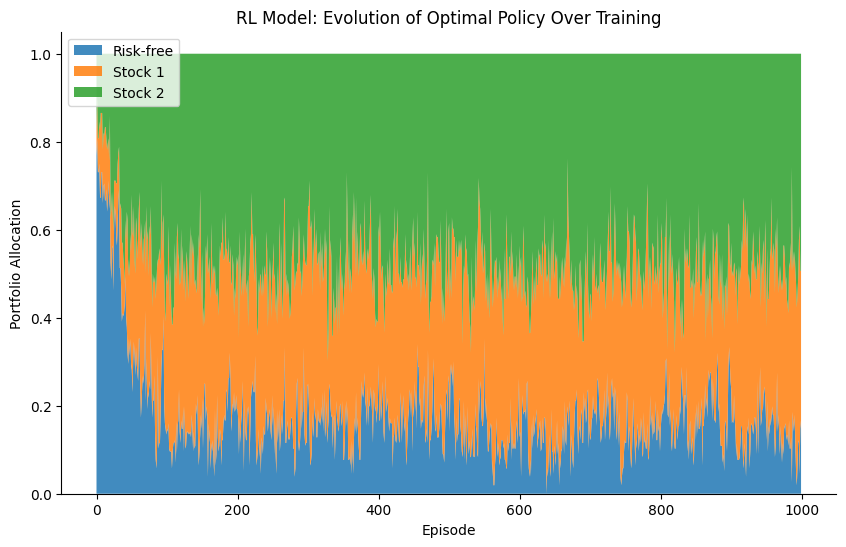

In [5]:
# Analysis of Policies
# Convert the list of optimal policies into a NumPy array for analysis.
optimal_policies = np.array(optimal_policies)

# Calculate the average allocation for each asset across all episodes.
average_allocations = optimal_policies.mean(axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.stackplot(range(num_episodes), average_allocations.T, labels=['Risk-free', 'Stock 1', 'Stock 2'], alpha=0.85)
plt.legend(loc='upper left')
plt.xlabel('Episode')
plt.ylabel('Portfolio Allocation')
plt.title('RL Model: Evolution of Optimal Policy Over Training')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("RL_evolution.png", format="png")
plt.show()


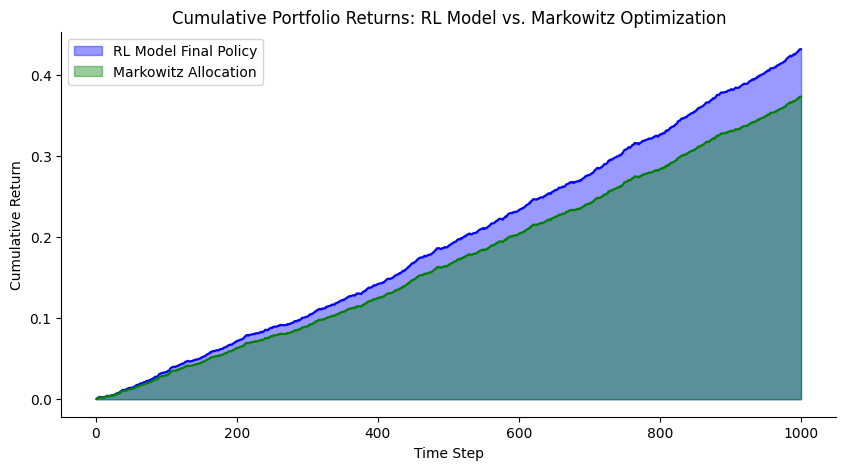

In [6]:
# Plotting comparative cumulative portfolio returns
# Final RL policy
final_rl_policy = optimal_policies[-1].mean(axis=0)

# Calculate portfolio values over time for RL policy
rl_portfolio_values = [np.dot(final_rl_policy, env.simulated_returns[i]) for i in range(env.num_steps)]
rl_cumulative_returns = np.cumprod(1 + np.array(rl_portfolio_values)) - 1

# Calculate portfolio values over time for Markowitz allocation
markowitz_portfolio_values = [np.dot(markowitz_weights, env.simulated_returns[i]) for i in range(env.num_steps)]
markowitz_cumulative_returns = np.cumprod(1 + np.array(markowitz_portfolio_values)) - 1

# Time steps for plotting
time_steps = range(1, env.num_steps + 1)

# Plotting
plt.figure(figsize=(10, 5))

# Fill area between x-axis (time_steps) and RL cumulative returns
plt.fill_between(time_steps, 0, rl_cumulative_returns, label='RL Model Final Policy', color='blue', alpha=0.4)
plt.plot(time_steps, rl_cumulative_returns, color='blue')

# Plot the line and fill area for Markowitz allocation
plt.fill_between(time_steps, 0, markowitz_cumulative_returns, label='Markowitz Allocation', color='green', alpha=0.4)
plt.plot(time_steps, markowitz_cumulative_returns, color='green')

plt.title('Cumulative Portfolio Returns: RL Model vs. Markowitz Optimization')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Return')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("Comparative_returns.png", format="png")
plt.show()


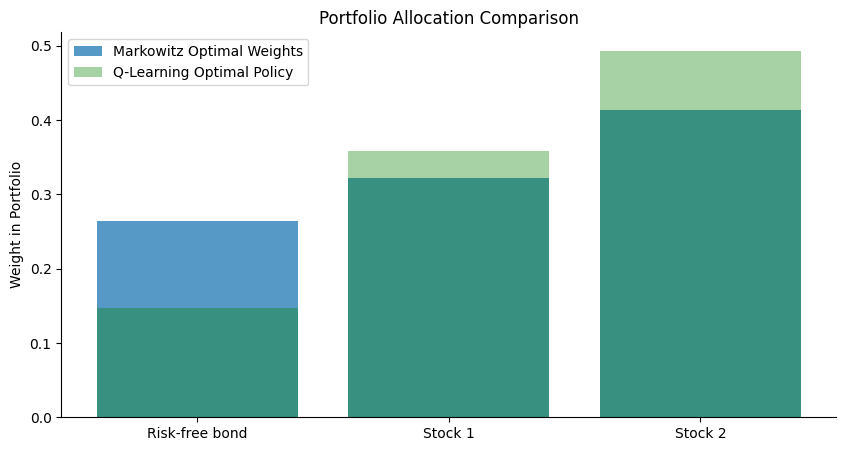

In [7]:
# Plotting
plt.figure(figsize=(10, 5))
plt.bar(range(len(markowitz_weights)), markowitz_weights, alpha=0.75, label='Markowitz Optimal Weights')
plt.bar(range(len(optimal_policy[-1])), final_rl_policy, color='green', alpha=0.35, label='Q-Learning Optimal Policy')
plt.xticks(range(len(expected_returns)), ['Risk-free bond', 'Stock 1', 'Stock 2'])
plt.ylabel('Weight in Portfolio')
plt.title('Portfolio Allocation Comparison')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("Allocation.png", format="png")
plt.show()
